# Building Markov Features

PyData - Amsterdam - 2019

In this notebook I am going to illustrate how to create Markov features from scratch.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pylab as plt

To run this notebook, some helpers will be used.

In [2]:
from helpers_ngrams import encode_states
from BigramModel import BigramModel
from datasets import make_bigram_toy_data

First, we will create some example dataset.

In [3]:
df = make_bigram_toy_data(n_samples=10000, n_sequences=1000, n_features=3)

In [4]:
df = df.dropna()
df["state"] = encode_states(df[["v{0}_diffsign".format(i) for i in range(3)]])

In [5]:
df.head()

,sequence,class,v0,v1,v2,v0_diffsign,v1_diffsign,v2_diffsign,state
0,0,0,-0.143406,0.108238,-0.044739,1,1,1,26
1,0,0,-0.201843,0.044729,-0.132554,-1,-1,-1,0
2,0,0,-0.217365,0.171169,-0.088315,-1,1,1,24
3,0,0,-0.272613,0.215179,-0.088315,-1,1,0,15
4,0,0,-0.312177,0.215179,-0.124545,-1,0,-1,3


Let us have a look at the data:

In [6]:
df0 = df[df["class"] == 0]
df0.head()

,sequence,class,v0,v1,v2,v0_diffsign,v1_diffsign,v2_diffsign,state
0,0,0,-0.143406,0.108238,-0.044739,1,1,1,26
1,0,0,-0.201843,0.044729,-0.132554,-1,-1,-1,0
2,0,0,-0.217365,0.171169,-0.088315,-1,1,1,24
3,0,0,-0.272613,0.215179,-0.088315,-1,1,0,15
4,0,0,-0.312177,0.215179,-0.124545,-1,0,-1,3


In [7]:
df1 = df[df["class"] == 1]
df1.head()

,sequence,class,v0,v1,v2,v0_diffsign,v1_diffsign,v2_diffsign,state
5000,500,1,0.139709,-0.059105,0.031076,1,1,1,26
5001,500,1,0.153008,-0.042231,-0.020024,1,1,-1,8
5002,501,1,0.108700,-0.028303,-0.014352,1,1,1,26
5003,502,1,0.126312,-0.047711,0.010822,1,1,1,26
5004,503,1,0.068327,0.036493,-0.064339,1,1,1,26


At this point we are ready to calculate the Markov features. For this I will use the class ```BigramModel```.

In [8]:
model_0 = BigramModel(alpha=1.0).fit(df0["state"], df0["sequence"])
model_1 = BigramModel(alpha=1.0).fit(df1["state"], df1["sequence"])

#### Display results
The ```fit``` will perform all the calculations and provide with all the calculations.

Let us have a look how frequent were the states in the data - sets.

In [9]:
print("First data-set: ", '\n',model_0.single_counts_df.sort_values(by='state').head(),
      '\n', "Second data-set: ", '\n', model_1.single_counts_df.sort_values(by='state').head())

First data-set:  
    state  frequency
0      0       1143
1      1        218
2      2        338
3      3        198
4      4         24 
 Second data-set:  
    state  frequency
0      0        502
1      1         41
2      2         81
3      3        253
4      4         21


Let us have a look on which are the most frequent sequences: 

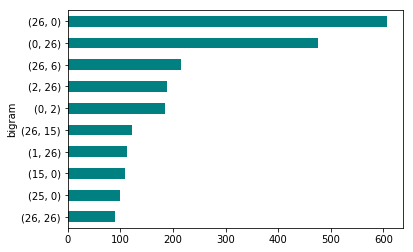

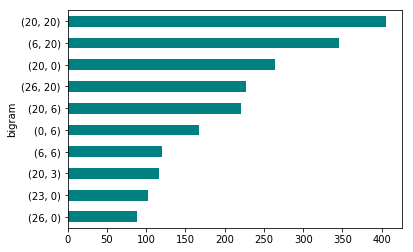

In [10]:
model_0.plot_frequency(n_most_frequent=10)
model_1.plot_frequency(n_most_frequent=10)

### Probability Matrix
Are you curious about the probability matrix? 
Let's have a look.

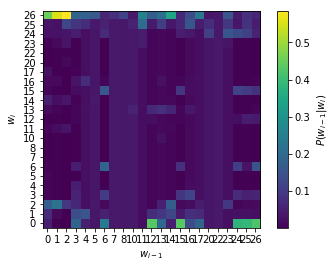

In [11]:
model_0.plot_proba_matrix(log=False)

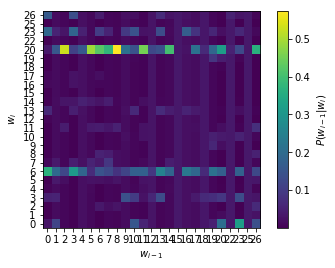

In [12]:
model_1.plot_proba_matrix(log=False)

We are ready to create Markov features.

In [13]:
model_0.predict_proba_stats(df1["state"].values, df1["sequence"].values).head()

,person_id,V_Markov_seq_prob_log_mean,V_Markov_seq_prob_log_median,V_Markov_seq_prob_log_tot,V_Markov_seq_prob_max,V_Markov_seq_prob_mean,V_Markov_seq_prob_median,V_Markov_seq_prob_min
0,500,-0.937852,-0.937852,-1.414973,0.115385,0.115385,0.115385,0.115385
1,503,-1.310095,-1.431364,-35.267589,0.244014,0.048967,0.037037,0.000701
2,504,-1.098205,-1.431364,-5.527756,0.244014,0.079762,0.037037,0.000959
3,505,-1.367124,-1.431364,-26.659128,0.256844,0.042941,0.037037,0.002817
4,506,-1.721290,-1.721290,-3.243073,0.037037,0.018998,0.018998,0.000959


If you would like to create more features, add them in the class and it will return them.

#### Are these features predective? 

In [14]:
probs1 = model_0.predict_proba_stats(df1["state"].values, df1["sequence"].values)["V_Markov_seq_prob_mean"].values
probs0 = model_0.predict_proba_stats(df0["state"].values, df0["sequence"].values)["V_Markov_seq_prob_mean"].values

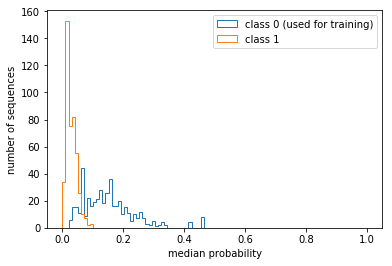

In [15]:
bins = np.linspace(0,1,100)
plt.hist(probs0, bins=bins, histtype="step", label="class 0 (used for training)")
plt.hist(probs1, bins=bins, histtype="step", label="class 1")
plt.xlabel("median probability")
plt.ylabel("number of sequences")
plt.legend(loc="upper right")
plt.show()

## Imputing missing values
Few words about missing values: 
- unseen states in the training, which you see in the test?
- missing values are present when in the data set are sequences with one state only
- imputing missing values is preferred be done outside the class
- example function below

In [16]:
def replace_Markov_missing_values(df, log_values = 0, nolog_values = 1):
    '''
    Retrieves all the Markov features, and replaces them by 1 or 0 if we have log or not
    Args:
        df (dataframe) : pandas dataframe with Markov features
        log_values (int): value to fill the missing values
        nolog_values (int): value to fill the missing values
    Returns:
        df (pandas dataframe): in this dataframe the missing values of the column col have been replaced
    '''
    for col in df.columns:
        if col.startswith('V_Markov_log'):
            df[col] = df[col].fillna(value = log_values)
        if col.startswith('V_Markov_seq'):
            df[col] = df[col].fillna(value = nolog_values)

    return df

# Conclusions

- Markov chain approximation is still a good approach for anomaly detection
- Web-collected data can be used to perform behavioural studies
- Markov chain-based features used together with other features in a complex model in production 